In [2]:
import numpy as np
import tifffile
import glob
import pandas
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import griottes
from saucisson import image_preparation

# Notebook for image segmentation
- Cut big image in small pieces for segmentation
- Reconstruct image
- Extract instensity in cell masks

### Load image

In [3]:
# Indicate path to the image you want to segment
# Install data from Zenodo repository, an example image is given in "Example_image\221212_6.tif")
IMAGE_PATH = r'Example_image'
img = tifffile.imread(os.path.join(IMAGE_PATH, '221212_6.tif'))
img = np.swapaxes(img, 0,2) # make sure channel order is x,y,c

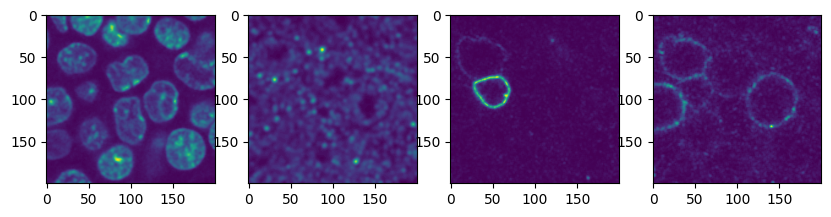

In [4]:
nx,ny,nc = img.shape

fig, ax = plt.subplots(1,nc, figsize = (10,3))

for i in range(nc):
    ax[i].imshow(img[5000:5200,5000:5200,i])

### Cut image in pieces 3000x3000 pixels

- The steps here cut the image in pieces 3000x3000 and place them in folders called saucisson_00, saucisson_01 ...
- The number of image per folder can be choose (here it is set to 100) : image_piece_0000.tif, image_piece_0001.tif, image_piece_0002.tif, image_piece_0003.tif ...
- If you use low calculation power for segmentation, place a low number of images inside each folder

In example data on Zenodo, the result of this step is in the folder "Example_image\saucisson_00"

In [5]:
multi_matrix, codex = image_preparation.image_cutter(
    img[...,0], # Channel containing DAPI signal
    max_image_size = 3000, # cut 3000x3000 pixels pieces in this example
    cut_in_z_direction = False,
    image_is_2D = True) # Put False for a 3D image

In [5]:
# Indicate here the path to the folder in which you want to save the piece of images
SAVE_PATH = os.path.join('Example_image')

In [ ]:
image_preparation.save_cut_images(multi_matrix,
                    SAVE_PATH,
                    dirname = 'saucisson_', # name of the folder containing image pieces saucisson_00, saucisson_01, ...
                    savename = 'image_piece_', # name of the different pieces of the image image_piece_0000.tif, image_piece_0001.tif, ...
                    number_images_per_batch = 100) # number of image piece per folder

### Here, you need to segment image fragments using Cellpose
- Cellpose will automatically create segmented files : image_piece_0000_seg.npy, image_piece_0001_seg.npy, image_piece_0002_seg.npy, image_piece_0003_seg.npy in the folder

In example data on Zenodo, the result of this step is in the folder "Example_image\saucisson_00"

### Reconstruct segmented image
We now need to reconstruction the full image by putting together the difference segmented pieces that are in the folder called saucisson_00 in our example

In [ ]:
image_name = '221212_6' # name of the image --> a tiff file called 221212_6_labeled here will be created containing an extra channel with cells masks
image_preparation.reconstruct_image(SAVE_PATH, # path 
                                    original_image = img, # original image with all channels
                                    codex = codex, # previously generated
                                    image_name = image_name,
                                    max_image_size = 3000, # size of pieces
                                    image_is_2D=True) # False for 3D image

### Visualize segmentation result

In [5]:
IMAGE_PATH = r'Z:\Marcia_Valentin\All\Data_and_code_paper\Data_Github\Example_image'
img_name = '221212_6_labeled.tif' # tif file generated previously with cell masks. This file can be find in the folder "Example_image"
img_seg = tifffile.imread(os.path.join(IMAGE_PATH, img_name))

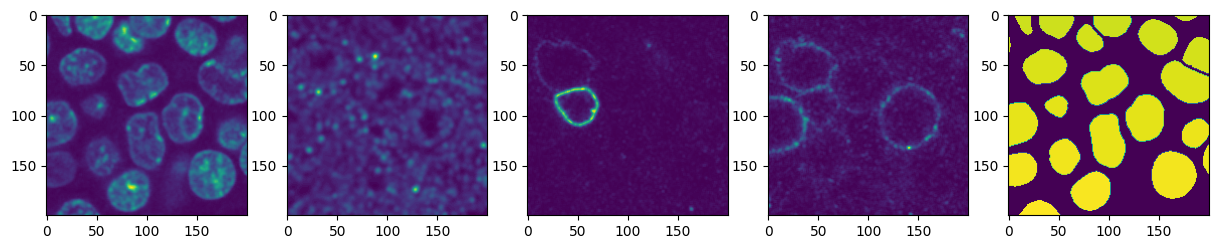

In [6]:
nx,ny,nc = img_seg.shape

fig, ax = plt.subplots(1,nc, figsize = (15,5))

for i in range(nc):
    ax[i].imshow(img_seg[5000:5200,5000:5200,i])

### Extract properties from image using Griottes
We use this tool to extract cell positions as well as the mean signal intensity signal inside cell masks for all channels.
This can be used later to classify cells based on nuclear staining using thresholding

In [8]:
img_seg_ = np.swapaxes(img_seg, 0,2) # griottes need shape C, Z, Y, X where C is the fluo channel.

In [ ]:
prop = griottes.analyse.cell_property_extraction.get_cell_properties(
    img_seg_, 
    mask_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    cell_geometry_properties = False,
    labeled_voronoi_tesselation = False,
    radius = 100,
    percentile = 95,
    min_area = 50,
    ndim = 2)

prop = prop.dropna()
prop['log_mean_intensity_0'] = np.log(prop.mean_intensity_0)
prop['log_mean_intensity_1'] = np.log(prop.mean_intensity_1)
prop['log_mean_intensity_2'] = np.log(prop.mean_intensity_2)
prop['log_mean_intensity_3'] = np.log(prop.mean_intensity_3)

In [ ]:
# Save resulting table. This file can be find in the folder "Example_image"
prop.to_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

### Cut small square 80x80 pixels around each cells
- Do this in all channels having membrane staining to classify these cells using neural network

In [3]:
prop = pandas.read_csv(os.path.join(IMAGE_PATH, '221212_6_labeled.csv'))

In [ ]:
selection_channel = 2 # Channel containing membrane signal
nuclei_channel = 0

image_preparation.cell_selection(
    img_seg,
    prop,
    nuclei_channel,
    selection_channel,
    dx = 80, # Size of the crop, here 80x80 pixels
    savedir= IMAGE_PATH,
)

selection_channel = 3 # Channel containing membrane signal
nuclei_channel = 0

image_preparation.cell_selection(
    img_seg,
    prop,
    nuclei_channel,
    selection_channel,
    dx = 80, # Size of the crop, here 80x80 pixels
    savedir= IMAGE_PATH,
)

### Note
An example of this procedure is given on a subset of 400 cells in this tutorial for easier visualization and navigation through the folders
You can find the resulting cutted image in the folder "Example_cell_classification_CD45"